# 1. Install Dependencies and Setup

In [ ]:
pip list

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 260 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

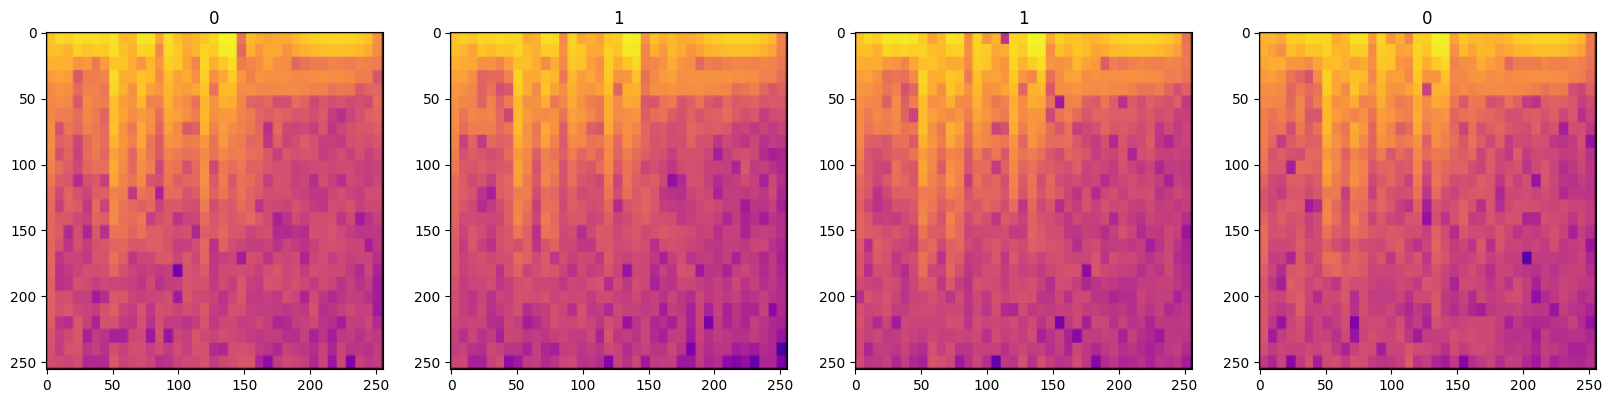

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.05448734, 0.04141038, 0.00847581],
          [0.20663236, 0.15657564, 0.03274016],
          [0.20868567, 0.15804228, 0.03318015],
          ...,
          [0.19296876, 0.09517463, 0.06985294],
          [0.19106212, 0.09429465, 0.06911962],
          [0.05037052, 0.02494309, 0.01816245]],
 
         [[0.25488603, 0.19324844, 0.04024628],
          [0.9647059 , 0.7315913 , 0.15490197],
          [0.9739277 , 0.73861825, 0.15687807],
          ...,
          [0.90072   , 0.44578737, 0.3268229 ],
          [0.89215684, 0.4413952 , 0.32352942],
          [0.23566996, 0.11638411, 0.08520418]],
 
         [[0.2599418 , 0.19685969, 0.04132966],
          [0.9829351 , 0.7456955 , 0.15880822],
          [0.99215686, 0.7529412 , 0.16078432],
          ...,
          [0.91764706, 0.45490196, 0.33333334],
          [0.90908396, 0.45029107, 0.33003983],
          [0.24036458, 0.11855086, 0.0870098 ]],
 
         ...,
 
         [[0.2262255 , 0.09679841, 0.10332415],
          [0.85810

# 5. Split Data

In [15]:
len(data)

9

In [16]:
10*.1

1.0

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [18]:
train_size + val_size + test_size

9

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
import tensorflow as tf

# Define the CNN architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='softmax')
])

In [22]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 128)     147584    
                                                        

# 7. Train

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

# 8. Plot Performance

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())

# 10. Test

In [ ]:
import cv2

In [ ]:
img = cv2.imread('./data/healthy/spectrograph_12.png')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is sad')
else:
    print(f'Predicted class is happy')

# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))